### Problem Statment
Task - The problem is mainly a BINARY IMAGE CLASSIFICATION PROBLEM. The Problem focuses on identifying the presence of metastases from a 96 * 96 digital histopathology images

This dataset is a combination of two independent datasets collected in Radboud University Medical Center (Nijmegen, the Netherlands), and the University Medical Center Utrecht (Utrecht, the Netherlands). The slides are produced by routine clinical practices and a trained pathologist would examine similar images for identifying metastases.

###### Also, one of the hing is that the problem states that the training Data contains 50/50 Images of both the labels i.e. the training contains equal proportion of both the labels, however on analysis it was found to be nearly equal to 70/30, which we will consider while we design the model

In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed
seed(101)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Setting Some Pre-Requisites
SAMPLE_SIZE = 500
SAMPLE_SIZE1 = 1000

Labels as per csv file

0 = no met tissue

1 = has met tissue.

In [3]:
# Creating a dataframe of all the training images

df_data = pd.read_csv(r'D:\AISHEISLD\Issue#403\histopathologic-cancer-detection/train_labels.csv')

# removing these images because it caused a training error previously
df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']


print(df_data.shape)

(220025, 2)


In [4]:
# Create the Train and Validation Sets

#Un Balanced 0-500 1-1000

df_0=df_data[df_data['label']==0].sample(SAMPLE_SIZE,random_state=101)
df_1=df_data[df_data['label']==1].sample(SAMPLE_SIZE1,random_state=101)

# concat the dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# shuffle
df_data = shuffle(df_data)

df_data['label'].value_counts()

1    1000
0     500
Name: label, dtype: int64

# Going to split 20% of the training set into a validation set

In [7]:
# Now, for the train-test split

# stratify=y creates a balanced validation set.
y = df_data['label']

df_train, df_val = train_test_split(df_data, test_size=0.20, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(1200, 2)
(300, 2)


In [9]:
df_train['label'].value_counts()

1    800
0    400
Name: label, dtype: int64

In [10]:
df_val['label'].value_counts()

1    200
0    100
Name: label, dtype: int64

Increasing the size of the image results in a much higher performance

In [11]:
IMAGE_SIZE = 196
IMAGE_CHANNELS = 3

In [12]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train_dir
    # a_no_met_tissue
    # b_has_met_tissue

# val_dir
    # a_no_met_tissue
    # b_has_met_tissue



# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)



# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
no_met_tissue = os.path.join(train_dir, 'a_no_met_tissue')
os.mkdir(no_met_tissue)
has_met_tissue = os.path.join(train_dir, 'b_has_met_tissue')
os.mkdir(has_met_tissue)


# create new folders inside val_dir
no_met_tissue = os.path.join(val_dir, 'a_no_met_tissue')
os.mkdir(no_met_tissue)
has_met_tissue = os.path.join(val_dir, 'b_has_met_tissue')
os.mkdir(has_met_tissue)

Transfer the images into the folders

In [13]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True ) 

In [15]:
# Get a list of train and val images
train_list = list(df_train['id'])
val_list = list(df_val['id'])


# Transfer the train images

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname_tif = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_met_tissue'
    if target == 1:
        label = 'b_has_met_tissue'
    
    # source path to image
    src = os.path.join(r'D:\AISHEISLD\Issue#403\histopathologic-cancer-detection\train', fname_tif)
    # change the new file name to png
    fname_png = image + '.png'
    # destination path to image
    dst = os.path.join(train_dir, label, fname_png)

    
    # read the file as an array
    cv2_image = cv2.imread(src)
    # save the image at the destination as a png file
    cv2.imwrite(dst, cv2_image)
    
    
# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname_tif = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_met_tissue'
    if target == 1:
        label = 'b_has_met_tissue'
    

    # source path to image
    src = os.path.join(r'D:\AISHEISLD\Issue#403\histopathologic-cancer-detection\train', fname_tif)
    # change the new file name to png
    fname_png = image + '.png'
    # destination path to image
    dst = os.path.join(val_dir, label, fname_png)

    
    # read the file as an array
    cv2_image = cv2.imread(src)
    # save the image at the destination as a png file
    cv2.imwrite(dst, cv2_image)

In [17]:
# Set up the generators
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = 'D:/AISHEISLD/Issue#403/histopathologic-cancer-detection/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)



datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 1200 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


# MODEL

In [18]:

kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (196, 196, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 194, 194, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 192, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 190, 190, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 95, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 95, 95, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 93, 93, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 91, 91, 64)        3

## Train the model

In [19]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [20]:
# Get the labels that are associated with each index
print(val_gen.class_indices)

{'a_no_met_tissue': 0, 'b_has_met_tissue': 1}


In [22]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callback_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=5, verbose=1,
                   callbacks =callback_list)

Epoch 1/5
120/120 [==============================] - 128s 1s/step - loss: 0.6123 - accuracy: 0.6717 - val_loss: 0.5292 - val_accuracy: 0.6900
Epoch 2/5
120/120 [==============================] - 126s 1s/step - loss: 0.5225 - accuracy: 0.7533 - val_loss: 0.5157 - val_accuracy: 0.7400
Epoch 3/5
120/120 [==============================] - 125s 1s/step - loss: 0.4763 - accuracy: 0.7858 - val_loss: 0.5002 - val_accuracy: 0.7700
Epoch 4/5
120/120 [==============================] - 125s 1s/step - loss: 0.4468 - accuracy: 0.8000 - val_loss: 0.5171 - val_accuracy: 0.7467
Epoch 5/5
120/120 [==============================] - 128s 1s/step - loss: 0.4391 - accuracy: 0.7950 - val_loss: 0.4957 - val_accuracy: 0.7900


In [23]:
# Here the best epoch will be used.

val_loss, val_acc = \
model.evaluate_generator(test_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

C:\Users\UVV2KOR\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


val_loss: 0.4957199692726135
val_acc: 0.7900000214576721


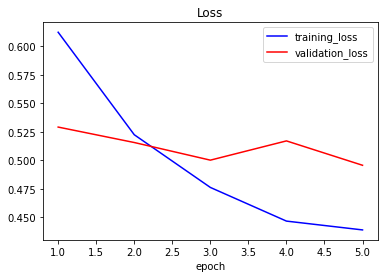

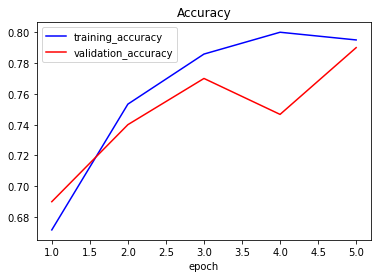

In [24]:
epochs = [i for i in range(1, len(history.history['loss'])+1)]

plt.plot(epochs, history.history['loss'], color='blue', label="training_loss")
plt.plot(epochs, history.history['val_loss'], color='red', label="validation_loss")
plt.legend(loc='best')
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

plt.plot(epochs, history.history['accuracy'], color='blue', label="training_accuracy")
plt.plot(epochs, history.history['val_accuracy'], color='red',label="validation_accuracy")
plt.legend(loc='best')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

# **Validation And Analysis**

Make a prediction on the val set

We need these predictions to calculate the AUC score.

In [25]:
# make a prediction
predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

  1/300 [..............................] - ETA: 49s

C:\Users\UVV2KOR\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


300/300 [==============================] - 9s 29ms/step


In [26]:
# Put the predictions into a dataframe.
# The columns need to be oredered to match the output of the previous cell

df_preds = pd.DataFrame(predictions, columns=['no_met_tissue', 'has_met_tissue'])

df_preds.head()

,no_met_tissue,has_met_tissue
0,0.006873,0.993127
1,0.630348,0.369652
2,0.200985,0.799015
3,0.633983,0.366017
4,0.837888,0.162112


What is the AUC Score?

In [27]:
# Get the true labels
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['has_met_tissue']

In [28]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

0.8124000000000001

MAKE A TEST SET PREDICTION

In [29]:
# This outputs the file names in the sequence in which 
# the generator processed the test images.
test_filenames = test_gen.filenames

# add the filenames to the dataframe
df_preds['file_names'] = test_filenames

df_preds.head()

,no_met_tissue,has_met_tissue,file_names
0,0.006873,0.993127,a_no_met_tissue\0150591da689866d1c35e99cc2af4f...
1,0.630348,0.369652,a_no_met_tissue\0423186255e941acc74d840ed7bf90...
2,0.200985,0.799015,a_no_met_tissue\0680a534938ebc52cd573cd30dbb8a...
3,0.633983,0.366017,a_no_met_tissue\06fee08f7dc39a9b4637749d974235...
4,0.837888,0.162112,a_no_met_tissue\0934c40cbcebe2d2568e663ec714c4...
